In [1]:
import networkx as nx
import pybind11
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import geopandas as gpd
import shapely 
import os
import marimo
import sys
from shapely import wkt
from shapely.geometry import Point
import random
from geopy.distance import geodesic
import re
os.chdir('/home/xuyuan/Desktop/2024 summer/real estate paper/oritignal cleaning/RealEstateBrokerage')

/home/xuyuan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [78]:
data = pd.read_stata('template.dta')

FileNotFoundError: [Errno 2] No such file or directory: 'template.dta'

In [3]:
codebook = {
    1: 'Beijing',
    2: 'Chengdu',
    3: 'Chongqing',
    4: 'Guangzhou',
    5: 'Hangzhou',
    6: 'Nanjing',
    7: 'Shanghai',
    8: 'Shenzhen',
    9: 'Tianjin',
    10: 'Wuhan'
}

data['city_id'] = data['city_id'].map(codebook)

In [4]:
map_data = data[(data['city_id'] == 'Beijing') & (data['year'] == 2016)]
map_data = gpd.GeoDataFrame(map_data, geometry = map_data.geometry.apply(wkt.loads))
df = pd.read_csv("classifying brokerages/processed/16_北京市.csv")
map_data['longitude'] = map_data['geometry'].apply(lambda point: point.x)
map_data['latitude'] = map_data['geometry'].apply(lambda point: point.y)

In [5]:
percentiles = np.arange(10, 91, 10)  # This will create an array from 10 to 90 inclusive
percentile_values = np.percentile(map_data['number'], percentiles).astype(float)  # Ensure they are float
np.set_printoptions(suppress=True)
# Create a DataFrame to display the results
percentile_values

array([ 1.,  2.,  3.,  4.,  6.,  9., 12., 18., 29.])

In [6]:
# the effect should be the number in the data
effects = map_data['number'].values
stores = df[['gpsx', 'gpsy']].values.tolist()
communities = map_data[['longitude', 'latitude']].values.tolist()


```
pip install pybind11

python3-config --cflags

pybind11-config --includes

cd /home/xuyuan/Desktop/2024 summer/real estate paper/writing/RealEstateBrokerage/network_estimation

g++ -O3 -shared -std=c++11 -fPIC -I/usr/include/python3.10 -I/home/xuyuan/.local/lib/python3.10/site-packages/pybind11/include -o network_formulation.so network_formulation.cpp
```

In [7]:
os.chdir('/home/xuyuan/Desktop/2024 summer/real estate paper/writing/RealEstateBrokerage/network_estimation')
import network_formulation

In [8]:
within_distance_meters = 410.0 # this is what we find in the RD design
# Perform network formation
network, edges = network_formulation.network_formation(stores, communities, effects, within_distance_meters)

In [22]:
df_edges = pd.DataFrame(edges, columns=["store_id_1", "store_id_2", "effect"])

In [23]:
df_network = pd.DataFrame([(i, j) for i, lst in enumerate(network) for j in lst], columns=["store_id", "community_id"])

In [61]:
# now we need to convert the problem using cpp
G = nx.Graph()

In [63]:
for i, (lon, lat) in enumerate(stores):
    G.add_node(f'Store {i}', pos=(lon, lat), color='red', shape='o')

# Add nodes for communities
for i, (lon, lat) in enumerate(communities):
    G.add_node(f'Community {i}', pos=(lon, lat), color='blue', shape='s')

# Add edges based on df_network
for _, row in df_network.iterrows():
    store_id = row['store_id']
    community_id = row['community_id']
    G.add_edge(f'Store {store_id}', f'Community {community_id}', color='gray', style='dotted')

# Add edges based on df_edges
for _, row in df_edges.iterrows():
    store_id_1 = row['store_id_1']
    store_id_2 = row['store_id_2']
    effect = row['effect']
    G.add_edge(f'Store {store_id_1}', f'Store {store_id_2}', weight=effect, color='black', style='solid')

In [64]:
start_node = random.choice([f'Store {i}' for i in range(len(stores))])

In [69]:
start_node = 'Store 357' # Store 357

In [70]:
bfs_edges = list(nx.bfs_edges(G, start_node, depth_limit=10))
bfs_nodes = set([start_node] + [v for u, v in bfs_edges])

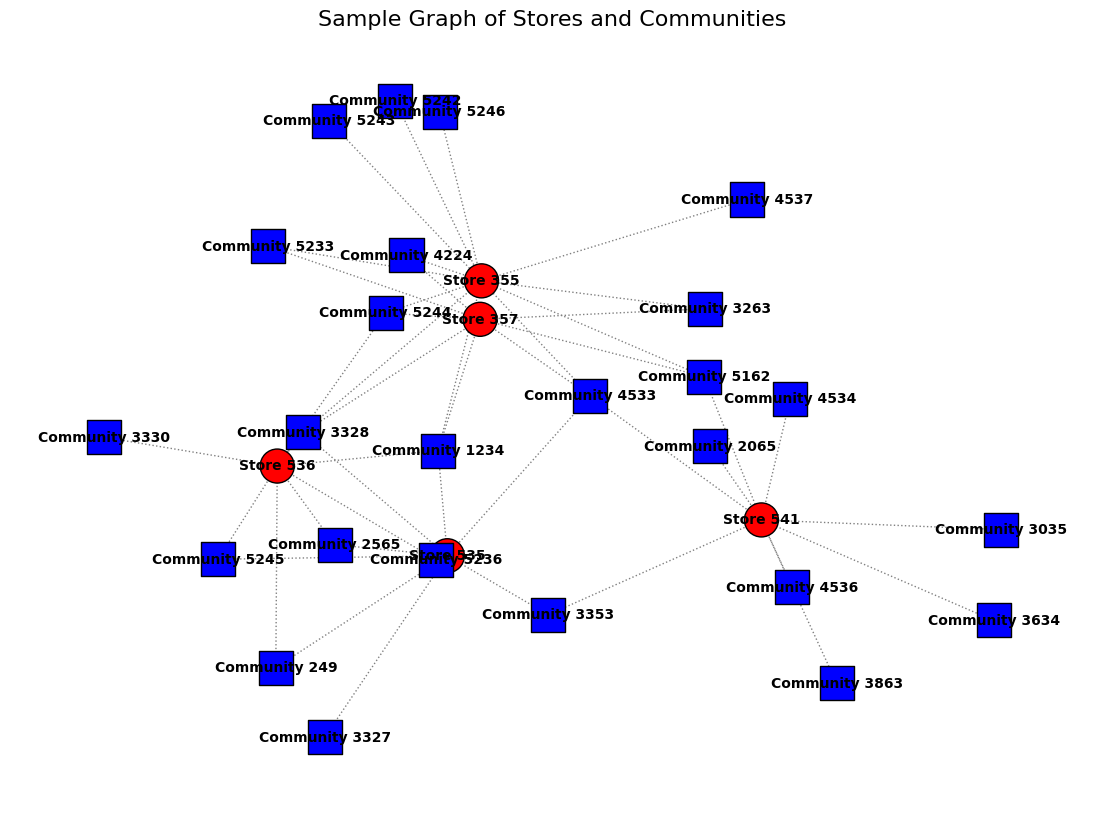

In [71]:
if start_node:
    # Perform BFS to get up to 10 neighbors
    bfs_edges = list(nx.bfs_edges(G, start_node, depth_limit=10))
    bfs_nodes = set([start_node] + [v for u, v in bfs_edges])

    # Subgraph for visualization
    H = G.subgraph(bfs_nodes)

    # Get positions for nodes
    pos = nx.get_node_attributes(G, 'pos')
    colors = nx.get_node_attributes(G, 'color')
    shapes = nx.get_node_attributes(G, 'shape')

    # Prepare the figure
    plt.figure(figsize=(14, 10))
    ax = plt.gca()

    # Draw nodes with specified colors and shapes
    for shape in set(shapes.values()):
        nx.draw_networkx_nodes(H, pos, nodelist=[node for node in H.nodes() if shapes[node] == shape],
                               node_color=[colors[node] for node in H.nodes() if shapes[node] == shape],
                               node_shape=shape, node_size=600, edgecolors='k')

    # Draw edges with different styles and widths based on effect
    for style in ['solid', 'dotted']:
        edges = [(u, v) for u, v, d in H.edges(data=True) if d['style'] == style]
        widths = [d['weight'] / 1000000 if 'weight' in d else 1 for u, v, d in H.edges(data=True) if d['style'] == style]
        colors = [d['color'] for u, v, d in H.edges(data=True) if d['style'] == style]
        nx.draw_networkx_edges(H, pos, edgelist=edges, width=widths, edge_color=colors, style=style)

    # Draw edge labels
    edge_labels = {(u, v): f'{d["weight"]:.2f}' for u, v, d in H.edges(data=True) if 'weight' in d}
    nx.draw_networkx_edge_labels(H, pos, edge_labels=edge_labels, font_color='red', font_size=8)

    # Draw node labels
    nx.draw_networkx_labels(H, pos, font_size=10, font_weight='bold')

    # Title and display
    plt.title('Sample Graph of Stores and Communities', fontsize=16)
    plt.axis('off')
    plt.show()
else:
    print("No connected stores available for visualization.")

In [73]:
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
# eigenvector_centrality = nx.eigenvector_centrality(G)

# Print centralities
print("Degree Centrality:", degree_centrality)
print("Betweenness Centrality:", betweenness_centrality)
print("Closeness Centrality:", closeness_centrality)
# print("Eigenvector Centrality:", eigenvector_centrality)

Degree Centrality: {'Store 0': 0.000812787862367922, 'Store 1': 0.000948252506095909, 'Store 2': 0.001625575724735844, 'Store 3': 0.001625575724735844, 'Store 4': 0.000406393931183961, 'Store 5': 0.000812787862367922, 'Store 6': 0.001490111081007857, 'Store 7': 0.000541858574911948, 'Store 8': 0.000948252506095909, 'Store 9': 0.000677323218639935, 'Store 10': 0.000812787862367922, 'Store 11': 0.001219181793551883, 'Store 12': 0.000948252506095909, 'Store 13': 0.000812787862367922, 'Store 14': 0.000677323218639935, 'Store 15': 0.000812787862367922, 'Store 16': 0.000677323218639935, 'Store 17': 0.000406393931183961, 'Store 18': 0.000948252506095909, 'Store 19': 0.000541858574911948, 'Store 20': 0.000948252506095909, 'Store 21': 0.000948252506095909, 'Store 22': 0.000677323218639935, 'Store 23': 0.000948252506095909, 'Store 24': 0.000541858574911948, 'Store 25': 0.000541858574911948, 'Store 26': 0.000270929287455974, 'Store 27': 0.001083717149823896, 'Store 28': 0.001083717149823896, 'Sto

In [77]:
degree_centrality_values = list(degree_centrality.values())
betweenness_centrality_values = list(betweenness_centrality.values())
closeness_centrality_values = list(closeness_centrality.values())

avg_degree_centrality = sum(degree_centrality_values) / len(degree_centrality_values)
avg_betweenness_centrality = sum(betweenness_centrality_values) / len(betweenness_centrality_values)
avg_closeness_centrality = sum(closeness_centrality_values) / len(closeness_centrality_values)


print(f'Average Degree Centrality: {avg_degree_centrality}')
print(f'Average Betweenness Centrality: {avg_betweenness_centrality}')
print(f'Average Closeness Centrality: {avg_closeness_centrality}')

Average Degree Centrality: 0.00026663581236013964
Average Betweenness Centrality: 2.7845936135810875e-06
Average Closeness Centrality: 0.0007898806013121978
